In the CW case, the average output $P$ is a parameter that you specify. The laser phase noise is modeled using the probability density function:

$$ \left( \Delta \phi\right) = \frac{1}{2\pi\sqrt{\Delta f \cdot dt}} \exp\left(-\frac{\Delta \phi^2}{4\pi \Delta f dt} \right) $$

where $\Delta \phi$ is the phase difference between two successive time instants and $dt$ is the time discretization. A Gaussian random variable for the phase difference between two successive time instants with zero mean and a variance equal to $2\pi \left( \Delta f \cdot dt \right)$ has been assumed, with $\Delta f$ as the laser line-width (which is equivalent to the full width half maximum (FWHM) of the laser power spectrum). The output is multiplied with a complex vector considering the state of polarization:
\begin{equation}
\begin{pmatrix}
E_x\left(t\right) \\
E_y\left(t\right)
\end{pmatrix} =
\begin{pmatrix}
\sqrt{1 - k} \\
\sqrt{k}e^{j \theta}
\end{pmatrix} \sqrt{P\left( t\right)}
\end{equation}
where the power splitting $k$ and the phase difference $\theta$ are related to the parameters Azimuth $\alpha$ and Ellipticity $\epsilon$ as follows:

\begin{align}
\tan\left(2\alpha\right) &= \frac{2 \sqrt{k\left(1 - k\right)} \cos\left(\theta \right) }{1 - 2k} \\
\sin\left( 2 \epsilon \right) &= 2 \sqrt{k\left(1-k\right)}\sin\left(\theta \right)
\end{align}


In [8]:
import os
import sys
sys.path.append('..\Functions')

from laser_dfb import *
from laser_cw import *
from AuxiliaryFunctions import *

import matplotlib.pyplot as plt
import numpy as np
from optic.dsp.core import firFilter, pulseShape, signal_power
from optic.utils import parameters
from optic.models.amplification import get_spectrum
from optic.models.devices import basicLaserModel

In [18]:
# simulation parameters
SpS = 16 # samples per symbol
M = 2 # order of the modulation format
Rs = 10e9 # Symbol rate (for OOK case Rs = Rb)
Nb = 2**16 # Number of bits

Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

# Laser parameters
laser_param = parameters()
laser_param.wavelength = 1550e-9 #m
laser_param.power  = 1e-3 #W
laser_param.linewith = 100e3 #hz
laser_param.initialPhase = 0 #rad

### Only X pol.

$$ \text{laserCw.Ex:  } ~~~~ E_x = \sqrt{P \cdot (1-k)} \cdot e^{\text{LaserPhase}} $$
$$ \text{laserCw.Ey:  } ~~~~ E_y = \sqrt{P \cdot k} \cdot e^{j\theta} \cdot e^{\text{LaserPhase}} $$

The laser phase is calculated by a random walk offset using the step $\Delta \phi$ (the calculation has already been shown in this notebook) + the time dependence

In [19]:
laser_param.polarization_alfa = 0 #rad [-pi/2;pi/2]
laser_param.polarization_ellp = 0 #rad [-pi/4;pi/4]
laser_cw = laser(laser_param, Nb*SpS, Fs)
print('Signal power e_x %.3f mW' %(1e3*signal_power(laser_cw.e_x)))
print('Signal power e_y %.3f mW' %(1e3*signal_power(laser_cw.e_y)))

Signal power e_x 1.000 mW
Signal power e_y 0.000 mW


Here, there's only phase/frequency noise. No amplitude noise was applied

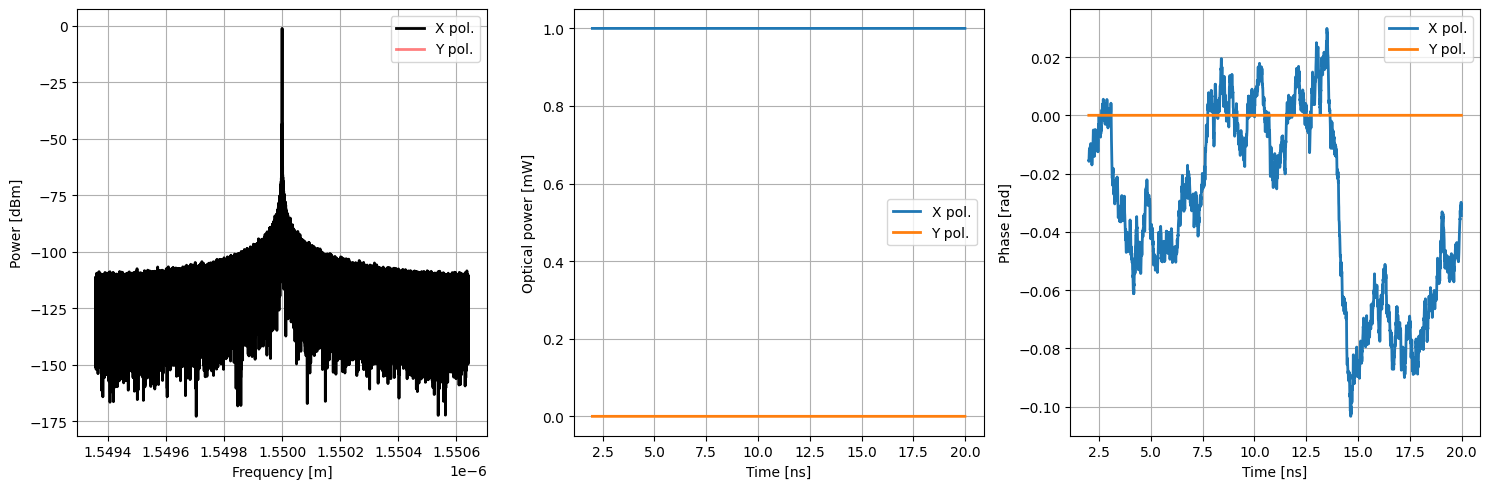

In [20]:
fig,ax = plt.subplots(1,3, figsize = (15,5))

laser_cw.plot(ax[0], xunits='m',yunits='dBm')

interval = np.arange(SpS*20,SpS*100*2)
t = interval*Ts/1e-9

ax[1].plot(t, 1e3*np.abs(laser_cw.e_x[interval])**2, label = 'X pol.', linewidth = 2,)
ax[1].plot(t, 1e3*np.abs(laser_cw.e_y[interval])**2, label = 'Y pol.', linewidth = 2)
ax[1].set_xlabel('Time [ns]')
ax[1].set_ylabel('Optical power [mW]')
# ax[1].set_ylim([0,1])
ax[1].grid()
ax[1].legend()

ax[2].plot(t, np.unwrap(np.angle(laser_cw.e_x[interval])), label = 'X pol.', linewidth = 2)
ax[2].plot(t, np.unwrap(np.angle(laser_cw.e_y[interval])), label = 'Y pol.', linewidth = 2)
ax[2].set_xlabel('Time [ns]')
ax[2].set_ylabel('Phase [rad]')
ax[2].grid()
ax[2].legend()

plt.tight_layout()

Text(0.5, 1.0, 'Laser linewidth (get) = 105.29 MHz')

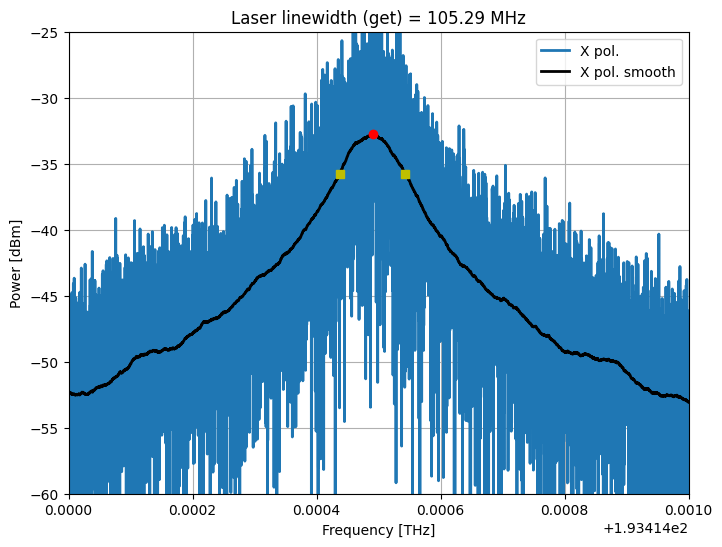

In [5]:
from scipy.constants import c
from scipy.signal import savgol_filter
freq, spectrum = get_spectrum(laser_cw.e_x, Fs=Fs, Fc=c/laser_cw.wavelength, xunits='Hz', yunits='dBm')
y = savgol_filter(spectrum, 801, 3)

fig = plt.figure(figsize=(8,6))
plt.plot(1e-12*freq, spectrum, label = 'X pol.', linewidth = 2)
plt.plot(1e-12*freq, y, 'k', label = 'X pol. smooth', linewidth = 2)
plt.title('Laser linewidth (set) = %.2f MHz'%(1e-6*laser_param.linewith))
plt.xlabel('Frequency [THz]')
plt.ylabel('Power [dBm]')
plt.xlim([193.414,193.415])
plt.ylim([-60,-25])
plt.legend()
plt.grid()

def find_nearest(array, value):
    return (np.abs(np.asarray(array) - value)).argmin()

indxMax = np.argmax(y)
plt.plot(1e-12*freq[indxMax], y[indxMax], 'ro')
indxl = indxMax + find_nearest(y[indxMax:], y[indxMax]-3)
plt.plot(1e-12*freq[indxl], y[indxl], 'ys')
indxu= find_nearest(y[:indxMax], y[indxMax]-3)
plt.plot(1e-12*freq[indxu], y[indxu], 'ys')
plt.title('Laser linewidth (get) = %.2f MHz'%(1e-6*np.abs((freq[indxu]-freq[indxl]))))

### X and Y pol. with same phase

In [6]:
laser_param.polarization_alfa = np.pi/4 #rad [-pi/2;pi/2]
laser_param.polarization_ellp = 0 #rad [-pi/4;pi/4]
laser_cw = laser(laser_param, Nb*SpS, Fs)
print('Signal power e_x %.3f mW' %(1e3*signal_power(laser_cw.e_x)))
print('Signal power e_y %.3f mW' %(1e3*signal_power(laser_cw.e_y)))

Signal power e_x 0.500 mW
Signal power e_y 0.500 mW


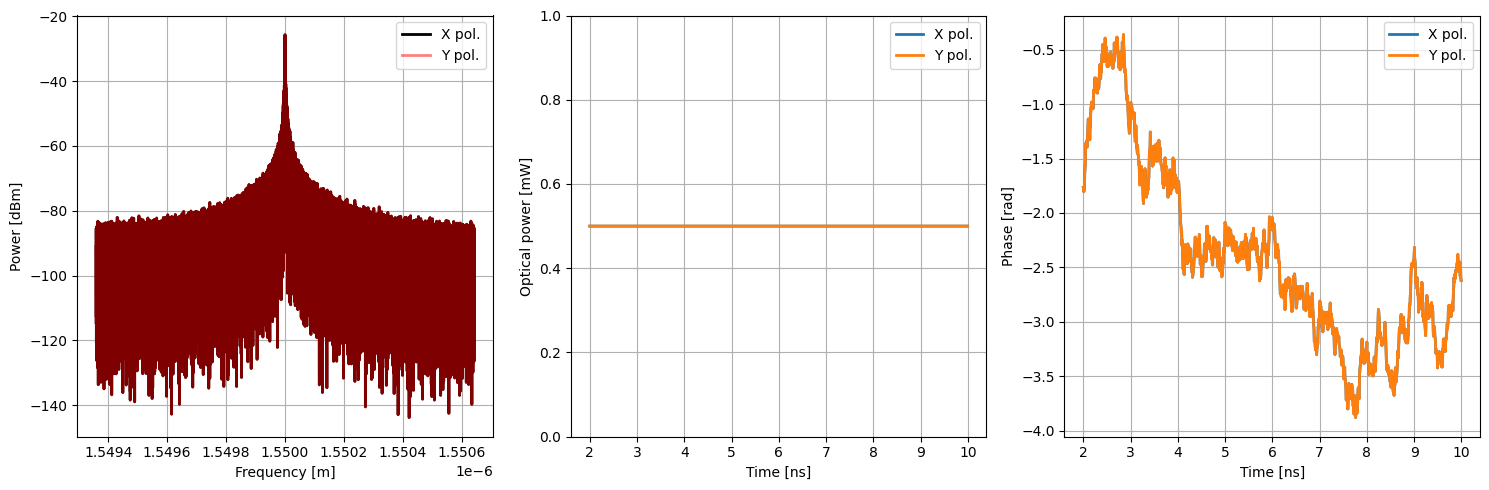

In [7]:
fig,ax = plt.subplots(1,3, figsize = (15,5))

laser_cw.plot(ax[0], xunits='m',yunits='dBm')

interval = np.arange(SpS*20,SpS*100)
t = interval*Ts/1e-9

ax[1].plot(t, 1e3*np.abs(laser_cw.e_x[interval])**2, label = 'X pol.', linewidth = 2,)
ax[1].plot(t, 1e3*np.abs(laser_cw.e_y[interval])**2, label = 'Y pol.', linewidth = 2)
ax[1].set_xlabel('Time [ns]')
ax[1].set_ylabel('Optical power [mW]')
ax[1].set_ylim([0,1])
ax[1].grid()
ax[1].legend()

ax[2].plot(t, np.unwrap(np.angle(laser_cw.e_x[interval])), label = 'X pol.', linewidth = 2)
ax[2].plot(t, np.unwrap(np.angle(laser_cw.e_y[interval])), label = 'Y pol.', linewidth = 2)
ax[2].set_xlabel('Time [ns]')
ax[2].set_ylabel('Phase [rad]')
ax[2].grid()
ax[2].legend()

plt.tight_layout()